# Computing line rates in the PanTaGruEl network

In [1]:
using PowerModels, TemperateOptimalPowerFlow
using DataFrames, CSV
using Plots, LaTeXStrings 
using ProgressMeter

In [2]:
using Gurobi
optimizer = get_silent_optimizer();

Set parameter TokenServer to value "gurobilm.hevs.ch"


Import the model:

In [3]:
network = parse_file("../models/pantagruel.json")

[info | PowerModels]: removing 2 cost terms from generator 788: Any[]
[info | PowerModels]: removing 2 cost terms from generator 1070: Any[]
[info | PowerModels]: removing 2 cost terms from generator 1067: Any[]
[info | PowerModels]: removing 2 cost terms from generator 1068: Any[]
[info | PowerModels]: removing 2 cost terms from generator 1069: Any[]
[info | PowerModels]: removing 2 cost terms from generator 1066: Any[]
[info | PowerModels]: removing 2 cost terms from generator 789: Any[]


Dict{String, Any} with 11 entries:
  "bus"      => Dict{String, Any}("4304"=>Dict{String, Any}("coord"=>Any[11.843…
  "name"     => "pantagruel"
  "dcline"   => Dict{String, Any}()
  "gen"      => Dict{String, Any}("1"=>Dict{String, Any}("model"=>2, "gen_bus"=…
  "branch"   => Dict{String, Any}("4304"=>Dict{String, Any}("br_r"=>0.00174284,…
  "storage"  => Dict{String, Any}()
  "switch"   => Dict{String, Any}()
  "baseMVA"  => 100
  "per_unit" => true
  "shunt"    => Dict{String, Any}()
  "load"     => Dict{String, Any}("3935"=>Dict{String, Any}("status"=>1, "load_…

In [4]:
loads = CSV.read("data/pantagruel_load_series.csv", DataFrame);

In [5]:
costs = CSV.read("data/pantagruel_gen_cost_series.csv", DataFrame);

Compute line rates without costs:

In [6]:
line_rates = compute_line_rates(network, optimizer)

Dict{String, Float64} with 8375 entries:
  "4304" => 0.302777
  "5422" => 0.0263316
  "3935" => 0.380205
  "5461" => 0.190532
  "2243" => 0.16125
  "8169" => 0.359792
  "1881" => 0.838119
  "5425" => 0.277755
  "4209" => 0.651821
  "1907" => 0.0406744
  "2923" => 0.193472
  "6753" => 0.0128018
  "7413" => 0.199175
  "599"  => 0.238006
  "2491" => 0.029084
  "5944" => 0.0262836
  "228"  => 0.129619
  "2590" => 0.887262
  "3697" => 0.0415805
  "5031" => 0.568676
  "2579" => 0.182293
  "5551" => 0.418424
  "3991" => 0.255867
  "2562" => 0.0375471
  "3215" => 0.468668
  ⋮      => ⋮

## Distibution of line rates

To visualize the effect of line costs, let us sample 100 different days and times at random:

In [7]:
# using StatsBase: sample
# timesteps_sample = sample([t for t=0:8735], 100, replace=false);

It can also be convenient to use a static sample for reproducibility:

In [21]:
timesteps_sample = collect(0:85:8735)
length(timesteps_sample)

103

The step of size $85 = 5 \cdot 17$ is chosen such that it is coprime with both $7$ and $24 = 2^3 \cdot 3$.

In this way, all hours of the day and all days of the week are equally represented in the sample:

In [9]:
[count(y -> y == x, timesteps_sample .% 24) for x = 0:23], [count(y -> y == x, timesteps_sample .% 7) for x = 0:6]

([5, 4, 5, 4, 5, 4, 5, 4, 4, 4  …  4, 5, 4, 5, 4, 4, 4, 4, 4, 4], [15, 15, 15, 15, 15, 14, 14])

Then compute the line rates for various costs:

In [10]:
function compute_line_rates_sample(line_cost::Real)
    result = Vector{Float64}()
    @showprogress for t in timesteps_sample
        assign_loads!(network, loads, t)
        assign_costs!(network, costs, t)
        add_line_costs!(network, line_cost)
        append!(result, collect(values(compute_line_rates(network, optimizer))))
    end
    result
end

compute_line_rates_sample (generic function with 1 method)

In [11]:
line_rates_sample_0 = compute_line_rates_sample(0);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


In [22]:
line_rates_sample_1000 = compute_line_rates_sample(1000);

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


In [23]:
line_rates_sample_5000 = compute_line_rates_sample(5000);

Progress: 100%|█████████████████████████████████████████| Time: 0:01:11


Plot the result in an histogram:

In [42]:
function log_ticks(exponent_min::Int, exponent_max::Int)
    ticks = reduce(vcat, [10.0^i * collect(1:9) for i = exponent_min:exponent_max])
    labels = [(i % 9 == 0) ? L"10^{%$(round(Int,i/9))}" : "" for i = (9*exponent_min):(9*exponent_max+8)]
    (ticks, labels)
end

function plot_histogram(data::Vector{Float64}, label::String="")
    x_ticks = ([x/20 for x = 0:20], [(x % 4 == 0) ? latexstring(x / 20) : "" for x = 0:20])
    stephist(data, bins=range(0, 1, length=21), label=label, linewidth=2,
        xlims=(0,1), xticks=x_ticks, xlabel=L"|P_i| / P_i^{therm.}",
        ylims=(1,1e6), yscale=:log10, yticks=log_ticks(0, 5), ylabel="Count",
        framestyle = :box, dpi=300, legend=:bottomleft)
end

function plot_histogram!(data::Vector{Float64}, label::String="")
    stephist!(data, bins=range(0, 1, length=21), label=label, linewidth=2)
end

plot_histogram! (generic function with 2 methods)

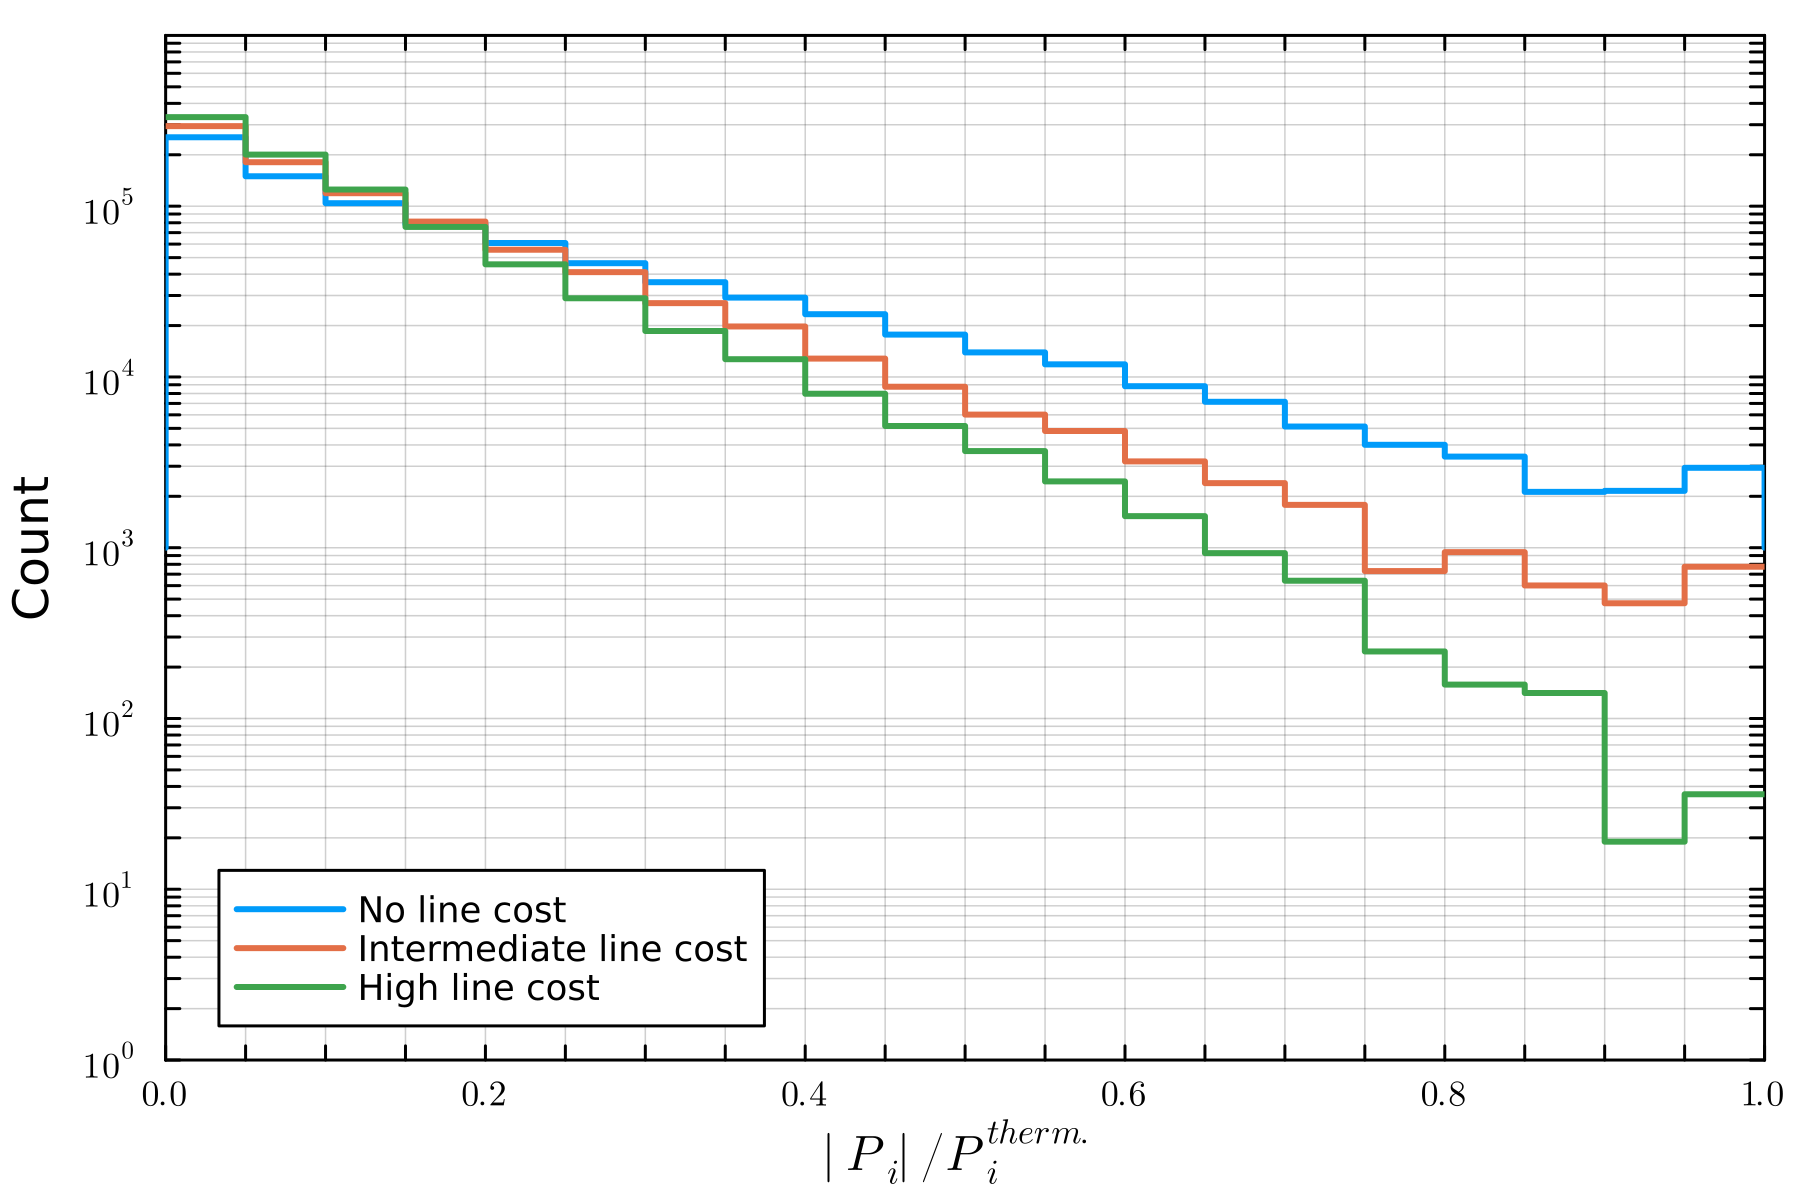

In [43]:
plot_histogram(line_rates_sample_0, "No line cost")
plot_histogram!(line_rates_sample_1000, "Intermediate line cost")
plot_histogram!(line_rates_sample_5000, "High line cost")

In [ ]:
# savefig("figures/pantagruel_line_rate_distribution.png")

Increasing the line cost further does not change the result significantly:

In [26]:
line_rates_sample_10000 = compute_line_rates_sample(10000);

Progress: 100%|█████████████████████████████████████████| Time: 0:01:09


In [27]:
line_rates_sample_20000 = compute_line_rates_sample(20000);

Progress: 100%|█████████████████████████████████████████| Time: 0:01:06


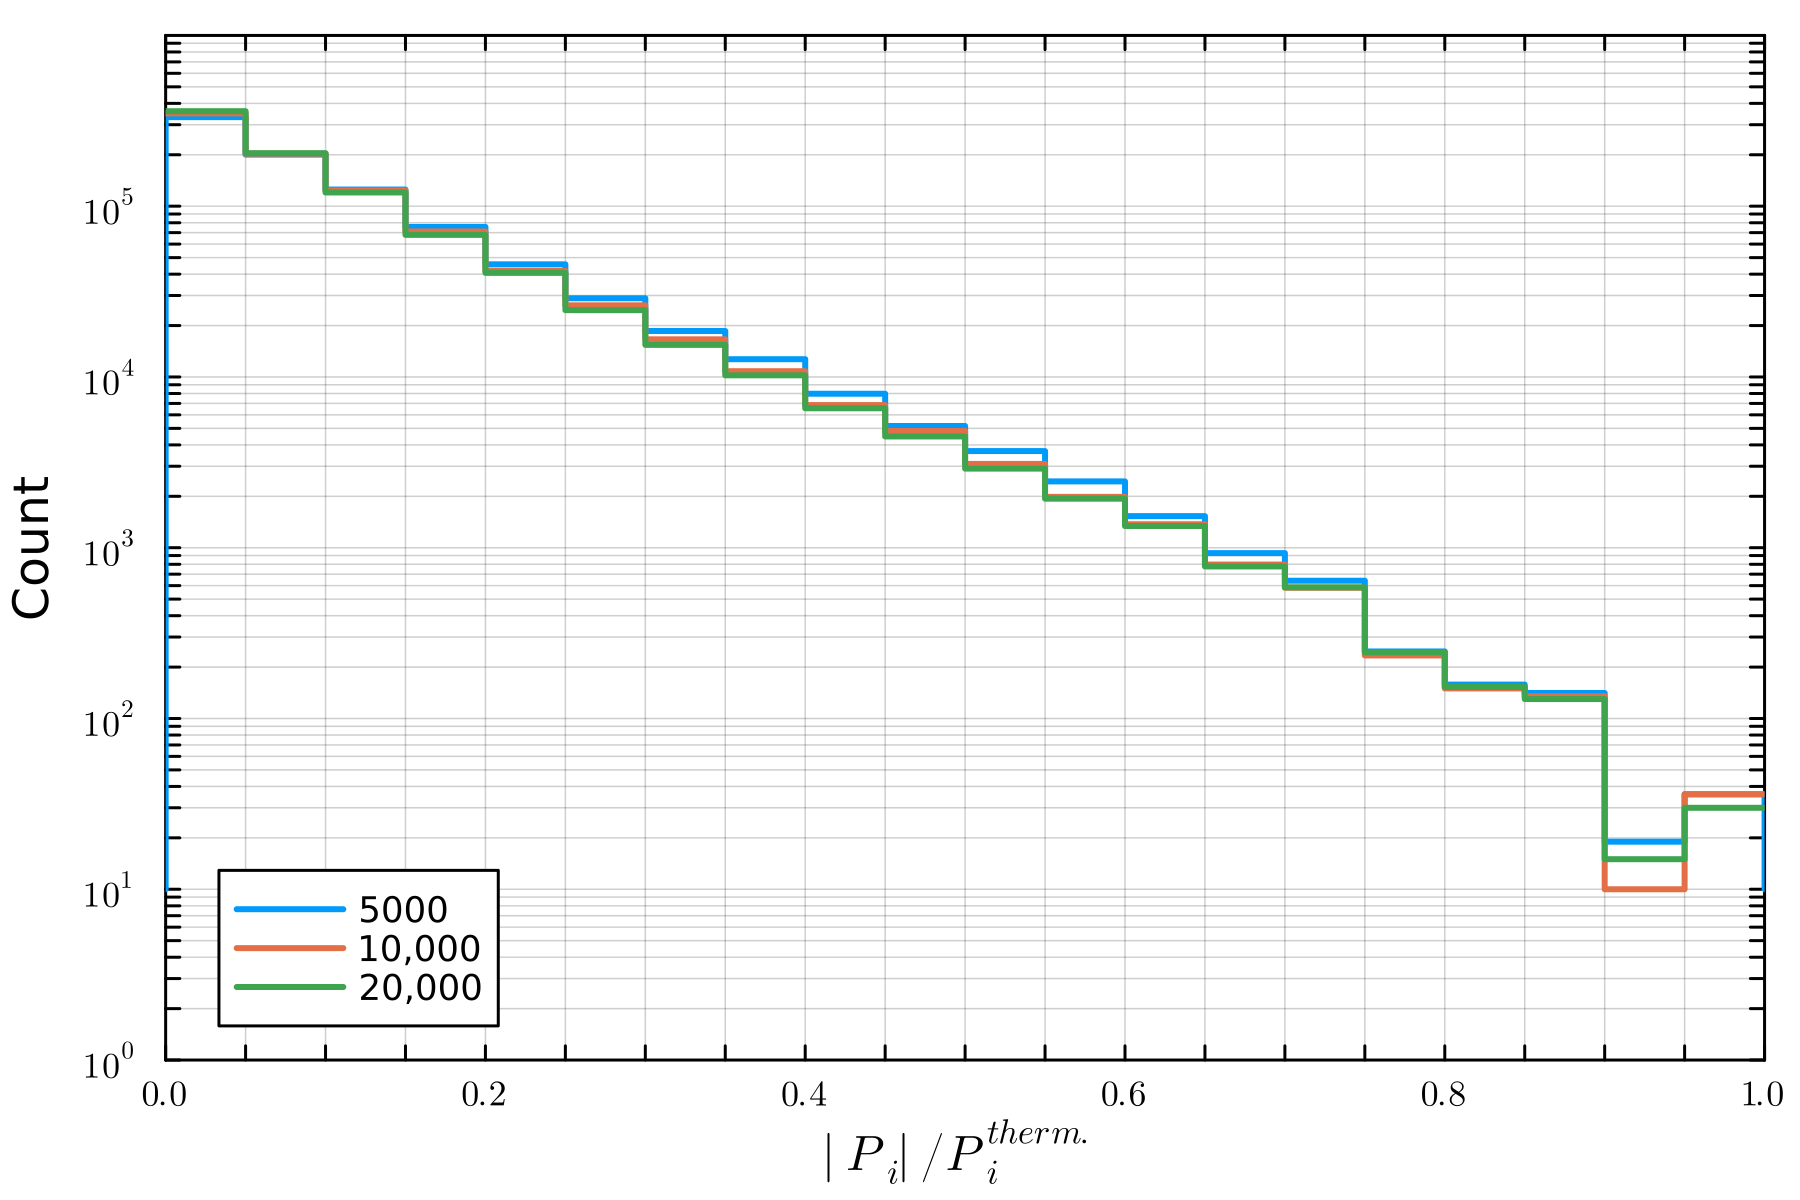

In [44]:
plot_histogram(line_rates_sample_5000, "5000")
plot_histogram!(line_rates_sample_10000, "10,000")
plot_histogram!(line_rates_sample_20000, "20,000")

## Choosing the right line cost

We can also count the number of lines above a certain threshold as a function of the line costs:

(this takes a long time to run!)

In [ ]:
# CSV file to store the dataframe
line_rate_thresholds_file = "data/pantagruel_line_rate_thresholds.csv"

# load the dataframe from file if it exists, otherwise create a new one
line_rate_thresholds = (isfile(line_rate_thresholds_file) ? CSV.read(line_rate_thresholds_file, DataFrame)
    : line_rate_thresholds = DataFrame(cost = Float64[], above90 = Float64[], above95 = Float64[], above99 = Float64[]))

# compute line rates above certain thresholds (90%, 95%, and 99%)
for exponent = 3:0.1:17
    cost = 2.0^exponent
    if cost ∉ line_rate_thresholds.cost
        println(exponent)
        line_rates = compute_line_rates_sample(cost)
        N = length(line_rates)
        push!(line_rate_thresholds, [cost ; [count(line_rates .> threshold) / N for threshold in [0.9, 0.95, 0.99]]])
    end
end

# sort and export the dataframe
sort!(line_rate_thresholds)
CSV.write(line_rate_thresholds_file, line_rate_thresholds)

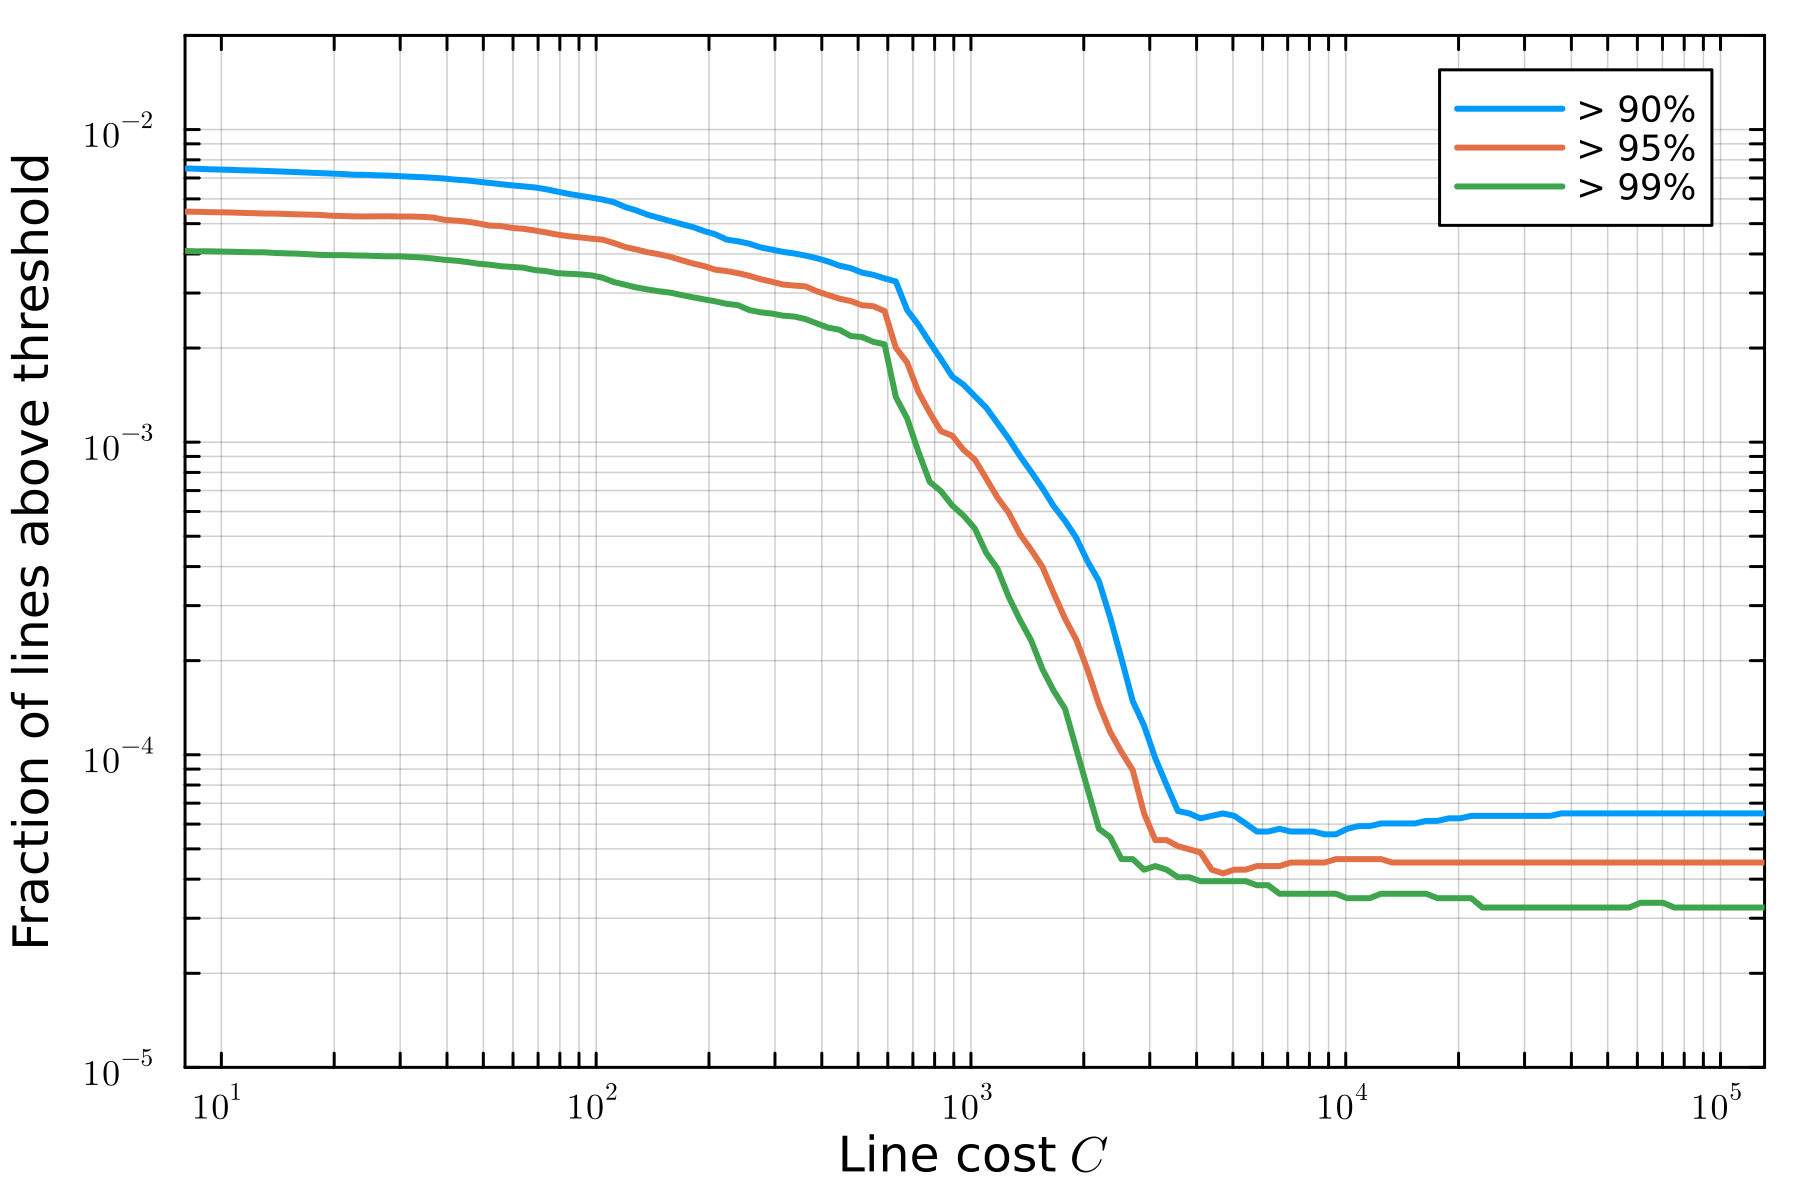

In [59]:
plot(line_rate_thresholds.cost, line_rate_thresholds.above90, label="> 90%", linewidth=2,
    framestyle=:box, dpi=300,
    xlims=(2^3, 2^17), xscale=:log10, xlabel=L"Line cost $C$", x_ticks = log_ticks(1, 5),
    ylims=(1e-5, 2e-2), yscale=:log10, ylabel="Fraction of lines above threshold", y_ticks = log_ticks(-5, -2))
plot!(line_rate_thresholds.cost, line_rate_thresholds.above95, label="> 95%", linewidth=2)
plot!(line_rate_thresholds.cost, line_rate_thresholds.above99, label="> 99%", linewidth=2)

In [60]:
# savefig("figures/pantagruel_line_rate_thresholds.png")

"/home/marc/repos/PowerData/doc/figures/pantagruel_line_rate_thresholds.png"

**We deduce that the optimal line cost for PanTaGruEL is around 3000.**